--------------
# Playbook 3 : CNN Model execution on Malaria data set
--------------
This playbooks takes the processed malaria data set colour images and runs the Liang CNN model against. The playbook also provides the following:

* Provide Accuracy, precision, recall and F1 scores for the various models.
* Builds models with different fractions of available training data to evaluate how the model performs as data is limited. 
* 10-fold cross validation tests are run on selected models and data fractions to get a view of how well models train and score on average.
* Looks at the typical mis-classified images from a model 


In [0]:
# Like a great many other libraries in Python, Keras is a mess of incompatability. 
# Need to use 2.2.4 or it breaks the CapsNet Code. I therefore standardise on 
# keras and tensorflow versions
!pip install gast==0.3.2
!pip install keras==2.2.4
!pip install tensorflow==1.15.2

## 1. Bring zipped data file across from gdrive to extract locally within colab

In [0]:
%env GPATH=/content/gdrive/My Drive/MSc AI/Project/msccode

from google.colab import drive
drive.mount('/content/gdrive')
!cp -f  "$GPATH/Datasets/processed-cell-images-malaria.zip" './processed-cell-images-malaria.zip'

## 2. Remove existing dataset and extract dataset zip file

In [0]:
!rm -rf cell_images
!rm -rf dataset
!unzip -q 'processed-cell-images-malaria.zip'
!ls

dataset  gdrive  processed-cell-images-malaria.zip  sample_data


## 3. Import required packages

In [0]:
%tensorflow_version 1.15 

import os
import shutil
import numpy as np
import cv2
import numpy as np
import keras as keras
import tensorflow as tf
import keras as keras
from numpy.random import seed
from tensorflow import set_random_seed

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


Using TensorFlow backend.


## 4. Define constants

In [0]:
IMG_SIZE = 44         # Data set images will be reframed to this width and height
TEST_FRACTION = 0.1   # Fraction of dataset to hold out for test purposes
VAL_SPLIT = 0.1       # Ammount of training data to use for validation
TEST_SPLIT = 0.1
BATCH_SIZE=32
EPOCHS=60

# Target image directory for 'processed' color images.
colorData = "./dataset/color/"
dstColorP = "./dataset/color/Parasitized/"
dstColorU = "./dataset/color/Uninfected/"

# Target image directory for 'processed' grayscale images.
grayData = "./dataset/gray/"
dstGrayP = "./dataset/gray/Parasitized/"
dstGrayU = "./dataset/gray/Uninfected/"

dataset_p_dirs=[dstColorP, dstGrayP]
dataset_u_dirs=[dstColorU, dstGrayU]

##5. Define function to load dataset into numpy arrays

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

def loadData(directory, labelMap, as_gray, quiet=True): 
    array_list = [] 
    label_list = []

    labels = [dn for dn in os.listdir(directory) if os.path.isdir(directory + '/' + dn)]

    for label in labels:
        classLabel = labelMap[label]
        subdir = directory + '/' + label
        files = [fn for fn in os.listdir(subdir) if fn.endswith(('.png'))] 
        print("Loading images for class {} from {}".format(classLabel, subdir))
        num_loaded = 0
        for img_file in files:
            file_path = subdir + '/' + img_file
            if as_gray is True:
                img = cv2.imread(file_path, 0)
            else:
                img = cv2.imread(file_path)
            img = img.astype('float32')
            array_list.append(img)
            label_list.append(classLabel)
            num_loaded += 1
            if not quiet:
                if num_loaded % 1000 == 0:
                    print("Loaded %d (of %d)..." %(num_loaded, len(files)))
        print("Completed loading %d (of %d) images" %(num_loaded, len(files)))
        print("")
        
    data = np.array(array_list)
    data /= 255.0
    return data, np.array(label_list)

def load_and_split_data(labelMap={"Uninfected": 0, "Parasitized":1},
                        gray=True, 
                        val_split=VAL_SPLIT, 
                        test_split=TEST_SPLIT):
    print("load_and_split_data called with Val/Test split fraction {}/{}".format(val_split, 
                                                                                 test_split))

    if gray: 
        data_X, data_Y  = loadData(grayData, labelMap, as_gray=True)
    else:
        data_X, data_Y  = loadData(colorData, labelMap, as_gray=False)
    idx = np.random.permutation(len(data_X))
    data_X, data_Y = data_X[idx], data_Y[idx]

    val_X = None; val_Y=None
    test_X = None; test_Y=None
    train_X = data_X; train_y = data_Y

    if test_split > 0:
        train_X, test_X, train_Y, test_Y = train_test_split(data_X, 
                                                            data_Y, 
                                                            test_size=test_split, 
                                                            stratify=data_Y)
    if val_split > 0:
        train_X, val_X, train_Y, val_Y = train_test_split(train_X, 
                                                          train_Y, 
                                                          test_size=val_split, 
                                                          stratify=train_Y)
    if gray:
        train_X = train_X.reshape(-1, IMG_SIZE,IMG_SIZE, 1).astype('float32')
        if val_split > 0:
            val_X = val_X.reshape(-1,IMG_SIZE,IMG_SIZE, 1).astype('float32')
        if test_split > 0:
            test_X = test_X.reshape(-1,IMG_SIZE,IMG_SIZE, 1).astype('float32')
    else:
        train_X = train_X.reshape(-1, IMG_SIZE,IMG_SIZE, 3).astype('float32')
        if val_split > 0:
            val_X = val_X.reshape(-1,IMG_SIZE,IMG_SIZE, 3).astype('float32')
        if test_split > 0:
            test_X = test_X.reshape(-1,IMG_SIZE,IMG_SIZE, 3).astype('float32')  

    print("Training data set size is", train_X.shape, train_Y.shape)
    if val_split > 0:
        print("Validation data set size is",val_X.shape, val_Y.shape)
    if test_split > 0:
        print("Test data data set size is",test_X.shape, test_Y.shape)

    labels, counts = np.unique(train_Y, return_counts=True)
    print("Training data labels and counts are", labels, counts)
    if val_split > 0:
        labels, counts = np.unique(val_Y, return_counts=True)
        print("Validation data labels and counts are", labels, counts)
    if test_split > 0:
        labels, counts = np.unique(test_Y, return_counts=True)
        print("Test data labels and counts are", labels, counts)

    return (train_X, train_Y, val_X, val_Y, test_X, test_Y)

def k_fold_load_and_split(gray, splits=10, data_frac=1, test_split=TEST_SPLIT):
    print("k_fold_load_and_split called for {}% data fraction".format(data_frac * 100))
    print("Test split {}%. Number of folds {}".format(test_split * 100,
                                                       splits))

    data_X, data_Y, _, _, test_X, test_Y = load_and_split_data(gray=gray, 
                                                               val_split=0,
                                                               test_split = test_split)

    # Take the required fraction of available training data. 
    if data_frac < 1:
        train_size = int(data_frac * data_X.shape[0])
        test_size = int(data_frac * test_X.shape[0])
        print("Limiting training data to {}/{} samples".format(train_size,
                                                               test_size))
        data_X = data_X[0:train_size]
        data_Y = data_Y[0:train_size]
        test_X = test_X[0:test_size]
        test_Y = test_Y[0:test_size]

    skf = StratifiedKFold(n_splits=splits, shuffle=False) 
    folds = skf.split(data_X, data_Y) 

    return (data_X, data_Y, folds, test_X, test_Y)

##6. Define function for showing mis-classified images

In [0]:
import matplotlib.pyplot as plt
import math 

# Plot mis-classified images
def show_misclassified(test_Y, pred_Y, ground_truth, file=None):
    pos = 1
    rows = 8
    cols = 10
    fig = plt.figure(figsize=(1.5*cols,1.5*rows))  
    for index in range(len(test_Y)):
        # Look for images where the test label is not the same as predicted
        if test_Y[index] != results[index]:
            pixels = test_X[index]
            #pixels = pixels.reshape((44,44,3))
            label = test_Y[index]
            if label == ground_truth:
                f = fig.add_subplot(rows,cols,pos)
                pos+=1
                f.set_title("T=%d P=%d"% (label, results[index]))
                f.set_xticks([])
                f.set_yticks([])
                plt.imshow(pixels)
            if pos > rows * cols:
                break

    plt.tight_layout()
    plt.show()

    if file is not None:
        fig.savefig(file)

##7. Define functions some utility functions for model performance and accuracy

###7.1 Define function to plot model performance

In [0]:
def plotModelPerf(history, sup = None, file=None):
    # Plot model training and validation loss and accuracy on one graph
    # history is an object provided by a fit() operation on a model
    
    print("Plotting Model accuracy and loss versus epoch")

    length = len(history.history["loss"])
    plt.style.use("ggplot")
    fig = plt.figure(figsize=(8,5))
    plt.plot(np.arange(0, length), history.history["loss"], label="train_loss") 
    plt.plot(np.arange(0, length), history.history["val_loss"], label="val_loss") 
    plt.plot(np.arange(0, length), history.history["acc"], label="train_acc") 
    plt.plot(np.arange(0, length), history.history["val_acc"], label="val_acc") 
    if sup is None:
        plt.title("Training Loss and Accuracy", y = 1.05, fontsize=12)
    else:
        plt.title("Training Loss and Accuracy: ({})".format(sup), y = 1.05, fontsize=12)

    plt.xlabel("Epoch #") 
    plt.ylabel("Loss/Accuracy") 
    plt.legend()

    plt.tight_layout()
    plt.show()

    if file is not None:
        fig.savefig(file)

###7.2 Define function to calculate model accuracy

In [0]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def getScores(model, test_X, test_Y):
    # Evaluate the model against the test data set.
    results = model.evaluate(test_X, test_Y, verbose=0)
    loss = results[0]
    accuracy = results[1]

    resultsProb = model.predict(test_X, verbose=0) 
    results = np.argmax(resultsProb, axis=1) 

    precision = precision_score(test_Y, results, average='binary')
    recall = recall_score(test_Y, results, average='binary')
    f1 = f1_score(test_Y, results, average='binary')
    return [loss, accuracy, precision, recall, f1]

def showScores(model, test_X, test_Y):
    loss, accuracy, precision, recall, f1 = getScores(model, test_X, test_Y)

    print("")
    print("Scores for classification model")   
    print("| %-8s | %-8s | %-9s | %-8s | %-8s"%
          ("Loss", "Accuracy", "Precision", "Recall", "F1"))
    print("| %-8s | %-8s | %-9s | %-8s | %-8s"%
          ('-' * 8, '-' * 8, '-' * 8, '-' * 8, '-' * 8)) 
    print("| %-8.3f | %-8.3f | %-9.3f | %-8.3f | %-8.3f"% 
          (loss, accuracy, precision, recall, f1))

    return [loss, accuracy, precision, recall, f1]

###7.3 Define wrapper function for model training

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
    
def trainModel(name, model, opt, trainX, trainY, valX, valY, batch, nepochs, verbose=1):  
    patience = nepochs//3
    if patience < 10:
       patience = 10
    es1 = EarlyStopping(monitor='val_acc', mode='max', baseline=0.70, patience=patience)

    mc = ModelCheckpoint(name, 
                         monitor='val_loss', 
                         mode='min', 
                         save_best_only=True)

    model.compile(optimizer=opt, 
                  loss="sparse_categorical_crossentropy", 
                  metrics=["accuracy"])
    
    history = model.fit(trainX, 
                        trainY, 
                        validation_data=(valX, valY),
                        batch_size=batch, 
                        epochs=nepochs,
                        callbacks=[es1, mc],
                        verbose=verbose)
    return history

##8. Build and run the Liang et al. Model

###8.1 Define the Model

In [0]:
class LiangCNNModel:
    def build(width, height, depth, classes):
      # initialize the model along with the input shape to be # "channels last"
      model = tf.keras.Sequential()
      inputShape = (height, width, depth)
      
      # First block CONV layer 1
      model.add(tf.keras.layers.Conv2D(32, (5, 5), 
                                       input_shape=inputShape, 
                                       activation='relu')) 
      # First block CONV layer 2
      model.add(tf.keras.layers.Conv2D(32, (5, 5), 
                                       activation='relu')) 
      model.add(tf.keras.layers.MaxPooling2D(pool_size=(5, 5), strides=(2,2)))
      
      # Second block CONV layer 1
      model.add(tf.keras.layers.Conv2D(64, (5, 5), 
                                       activation='relu')) 
      # Second block CONV layer 2
      model.add(tf.keras.layers.Conv2D(64, (3, 3)))
      model.add(tf.keras.layers.AveragePooling2D(pool_size=(3, 3), strides=(1,1)))

      # Third block CONV layer 1
      model.add(tf.keras.layers.Conv2D(128, (5, 5), 
                                       activation='relu')) 
      # Third block CONV layer 2
      model.add(tf.keras.layers.Conv2D(256, (4, 4)))

      # Fourth Block set of FC => RELU layers 
      model.add(tf.keras.layers.Flatten()) 
      model.add(tf.keras.layers.Dense(256, activation='relu')) 
      model.add(tf.keras.layers.Dense(256, activation='relu')) 
      model.add(tf.keras.layers.Dense(classes,activation='sigmoid')) 

      # softmax classifier
      model.add(tf.keras.layers.Dense(classes, activation='softmax'))

      # return the constructed network architecture 
      return model

In [0]:
GRAY=False
CHANNELS=1
if not GRAY:
    CHANNELS=3

### 8.2 Simple test with no Cross Validation

In [0]:
(train_X, train_Y, val_X, val_Y, test_X, test_Y) = load_and_split_data(gray=GRAY)

load_and_split_data called with Val/Test split fraction 0.1/0.1
Loading images for class 0 from ./dataset/color//Uninfected
Completed loading 13779 (of 13779) images

Loading images for class 1 from ./dataset/color//Parasitized
Completed loading 13779 (of 13779) images

Training data set size is (22321, 44, 44, 3) (22321,)
Validation data set size is (2481, 44, 44, 3) (2481,)
Test data data set size is (2756, 44, 44, 3) (2756,)
Training data labels and counts are [0 1] [11161 11160]
Validation data labels and counts are [0 1] [1240 1241]
Test data labels and counts are [0 1] [1378 1378]


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 40, 40, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 36, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 64)        51264     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
average_pooling2d (AveragePo (None, 8, 8, 64)          0         
_________________________________________

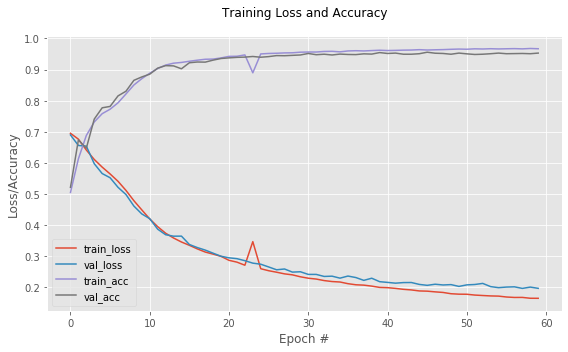


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.188    | 0.956    | 0.952     | 0.961    | 0.956   


In [0]:
seed(1)
set_random_seed(2)

model = LiangCNNModel.build(IMG_SIZE, IMG_SIZE, CHANNELS, 2)
print (model.summary())

opt = tf.keras.optimizers.Adagrad(learning_rate=0.005)
history = trainModel('3_Best_CNN_model.h5',
                     model, 
                     opt, 
                     train_X, train_Y, 
                     val_X, val_Y, 
                     batch=BATCH_SIZE, 
                     nepochs=EPOCHS)
plotModelPerf(history)
scores = showScores(model, test_X, test_Y)

In [0]:
# load a saved model
from tensorflow.keras.models import load_model
best_model = load_model('3_Best_CNN_model.h5')
scores = showScores(best_model, test_X, test_Y)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.166    | 0.967    | 0.961     | 0.975    | 0.968   


###8.3 Test with 10-fold Cross Validation

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

def cv_test(train_X, train_Y, folds, test_X, test_Y, bs=BATCH_SIZE, nepochs=EPOCHS, tresh=80):
    cvscores = []
    es1 = EarlyStopping(monitor='acc', mode='max', baseline=0.70, patience=nepochs//3)

    iter = 0
    for train_index, test_index in folds:
        iter += 1
        print("Build and train on fold number {}".format(iter))
        mc = ModelCheckpoint('3_Best_CNN_CV_model_{}.h5'.format(iter), 
                             monitor='loss', 
                             mode='min', 
                             save_best_only=True)
        model_accepted = False
        while model_accepted == False:
            model = LiangCNNModel.build(IMG_SIZE, IMG_SIZE, CHANNELS, 2)
            opt = tf.keras.optimizers.Adagrad(learning_rate=0.005)

            model.compile(optimizer=opt, 
                          loss="sparse_categorical_crossentropy", 
                          metrics=["accuracy"])
      
            model.fit(train_X[train_index] , 
                      train_Y[train_index], 
                      batch_size=bs, 
                      epochs=nepochs, 
                      verbose = 0,
                      callbacks=[es1,mc])

            # evaluate the model
            scores = model.evaluate(train_X[test_index], 
                                    train_Y[test_index], 
                                    verbose=0)
            print("\t%s: %.2f%% {} model score at end of training (with fold test data)" % (model.metrics_names[1], scores[1]*100))
            if scores[1]*100 > tresh:
                model_accepted = True 
                best_model = load_model('3_Best_CNN_CV_model_{}.h5'.format(iter))
                scores = getScores(best_model,
                                   test_X, 
                                   test_Y)
                print("\t%s: %.2f%% best model score on test set" % (model.metrics_names[1], scores[1]*100))
                cvscores.append(scores)
            else:
                print("\tModel rejected. trying again")
 
    return cvscores

In [0]:
(train_X, train_Y, folds, test_X, test_Y) = k_fold_load_and_split(gray=GRAY, splits=10)
print("")
cvscores = cv_test(train_X, train_Y, folds, test_X, test_Y)
mu, std = np.mean(cvscores, axis=0), np.std(cvscores, axis=0)
print("")
print("Cross validation mean loss on test data %.3f (+/- %.3f)"% (mu[0], std[0]))
print("Cross validation mean accuracy on test data %.2f%% (+/- %.2f%%)"% (mu[1]*100, std[1]*100))
print("Cross validation mean precision on test data %.3f (+/- %.3f)"% (mu[2], std[2]))
print("Cross validation mean recall on test data %.3f (+/- %.3f)"% (mu[3], std[3]))
print("Cross validation mean F1 on test data %.3f (+/- %.3f)"% (mu[4], std[4]))

k_fold_load_and_split called for 100% data fraction
Test split 10.0%. Number of folds 10
load_and_split_data called with Val/Test split fraction 0/0.1
Loading images for class 0 from ./dataset/color//Uninfected
Completed loading 13779 (of 13779) images

Loading images for class 1 from ./dataset/color//Parasitized
Completed loading 13779 (of 13779) images

Training data set size is (24802, 44, 44, 3) (24802,)
Test data data set size is (2756, 44, 44, 3) (2756,)
Training data labels and counts are [0 1] [12401 12401]
Test data labels and counts are [0 1] [1378 1378]

Build and train on fold number 1
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
	acc: 95.12% {} model score at end of training (with fold test data)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructi

##9. Model performance with different fractions of available training data

In [0]:
def frac_test(fracs, train_X, train_Y, val_X, val_Y, tresh=80):
    histories = []
    models = []

    for frac in fracs:
        print("Training model on {}% of training data".format(frac))

        seed(13)
        set_random_seed(13)
        train_size = int(frac * train_X.shape[0]/100)
        val_size = int(frac * val_X.shape[0]/100)
        sub_train_X = train_X[0:train_size]
        sub_train_y = train_Y[0:train_size]
        sub_val_X = val_X[0:val_size]
        sub_val_Y = val_Y[0:val_size]
       
        keep_model = False
        while keep_model == False:
            sub_model = LiangCNNModel.build(IMG_SIZE, IMG_SIZE, CHANNELS, 2)
            opt = tf.keras.optimizers.Adagrad(learning_rate=0.005)
            
            #
            # Give every model the same number of mini-batchs for parameter adjusment 
            # (data_set * frac * 10 * EPOCHS/frac)/(10 * BATCH_SIZE)  
            #
            sub_history = trainModel('3_Best_CNN_model_frac_{}.h5'.format(frac),
                                    sub_model, 
                                    opt, f
                                    sub_train_X, 
                                    sub_train_y, 
                                    sub_val_X, 
                                    sub_val_Y, 
                                    batch=BATCH_SIZE, 
                                    nepochs=EPOCHS*100//frac,
                                    verbose=0)
            best_model = load_model('3_Best_CNN_model_frac_{}.h5'.format(frac))

            scores = sub_model.evaluate(sub_val_X, 
                                        sub_val_Y, 
                                        verbose=0)

            if scores[1]*100 > tresh:
                keep_model = True 
                histories.append(sub_history)
                models.append(best_model)
            else:
                # Model did'nt train to satisfaction (< tresh accuracy at tend of training)
                # So try again.
                print("\tModel rejected. trying again")


    return models, histories

In [0]:
(train_X, train_Y, val_X, val_Y, test_X, test_Y) = load_and_split_data(gray=GRAY)

load_and_split_data called with Val/Test split fraction 0.1/0.1
Loading images for class 0 from ./dataset/color//Uninfected
Completed loading 13779 (of 13779) images

Loading images for class 1 from ./dataset/color//Parasitized
Completed loading 13779 (of 13779) images

Training data set size is (22321, 44, 44, 3) (22321,)
Validation data set size is (2481, 44, 44, 3) (2481,)
Test data data set size is (2756, 44, 44, 3) (2756,)
Training data labels and counts are [0 1] [11160 11161]
Validation data labels and counts are [0 1] [1241 1240]
Test data labels and counts are [0 1] [1378 1378]


Training model on 10% of training data
Training model on 20% of training data
Training model on 40% of training data
	Model rejected. trying again
Training model on 60% of training data
	Model rejected. trying again
Training model on 80% of training data
Training accuracy for model 1 with 10 % data
Plotting Model accuracy and loss versus epoch


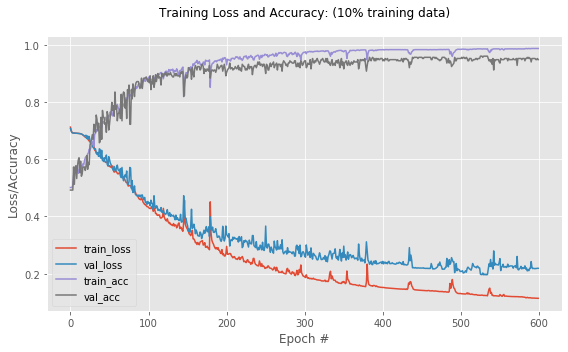


Training accuracy for model 2 with 20 % data
Plotting Model accuracy and loss versus epoch


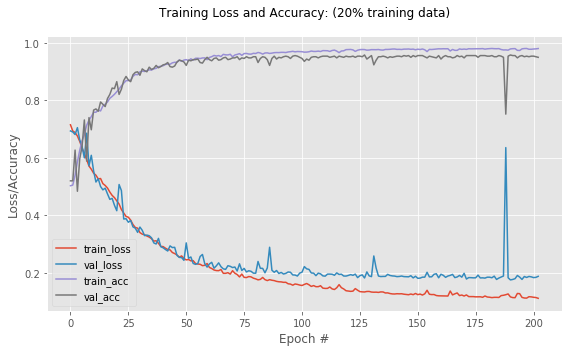


Training accuracy for model 3 with 40 % data
Plotting Model accuracy and loss versus epoch


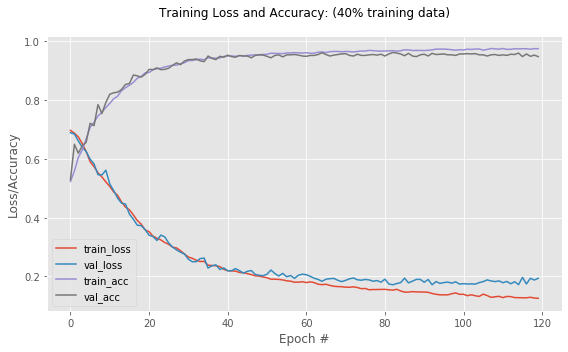


Training accuracy for model 4 with 60 % data
Plotting Model accuracy and loss versus epoch


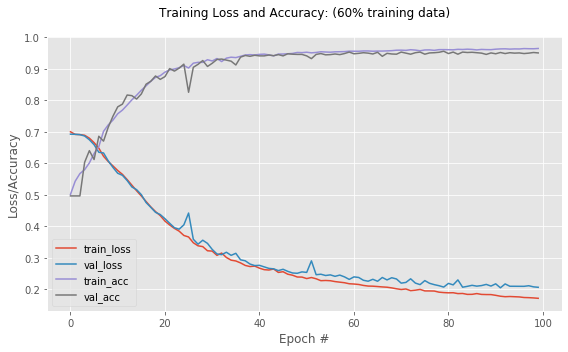


Training accuracy for model 5 with 80 % data
Plotting Model accuracy and loss versus epoch


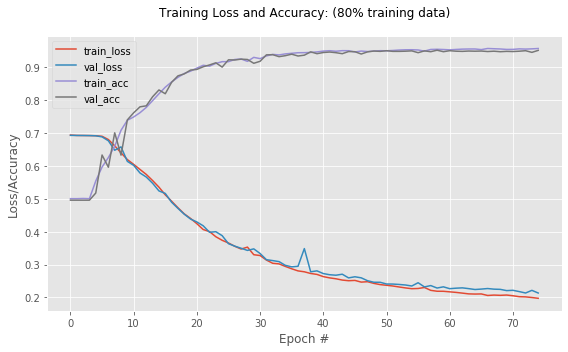


Model accuracy with hold out data for model 1 with 10 % data

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.241    | 0.933    | 0.940     | 0.925    | 0.933   
Model accuracy with hold out data for model 2 with 20 % data

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.204    | 0.944    | 0.955     | 0.933    | 0.944   
Model accuracy with hold out data for model 3 with 40 % data

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.195    | 0.946    | 0.961     | 0.930    | 0.945   
Model accuracy with hold out data for model 4 with 60 % data

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.212

In [0]:
fracs = [10,20,40,60,80]
models, histories = frac_test(fracs, train_X, train_Y, val_X, val_Y)

for index in range(len(histories)):
    print("Training accuracy for model {} with {} % data".format(index + 1, fracs[index]))
    plotModelPerf(histories[index],
                  sup= "{}% training data".format(fracs[index]),
                  file="3_CNN_model_frac{}".format(fracs[index]))
    print('')

for index in range(len(models)):
    print("Model accuracy with hold out data for model {} with {} % data".format(index + 1, fracs[index]))
    showScores(models[index], test_X, test_Y)

Training model on 8% of training data
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Training model on 5% of training data
Training model on 4% of training data
Training model on 2% of training data
	Model rejected. trying again
Epoch 01189: early stopping
Training accuracy for model 1 with 8 % data
Plotting Model accuracy and loss versus epoch


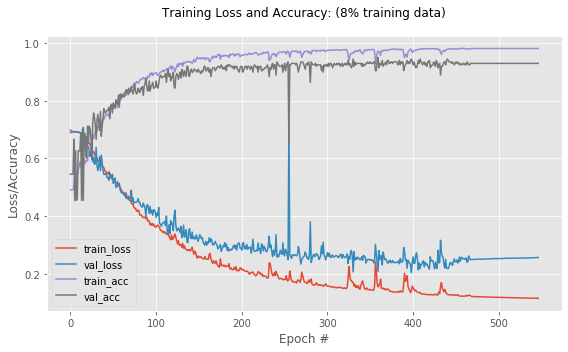


Training accuracy for model 2 with 5 % data
Plotting Model accuracy and loss versus epoch


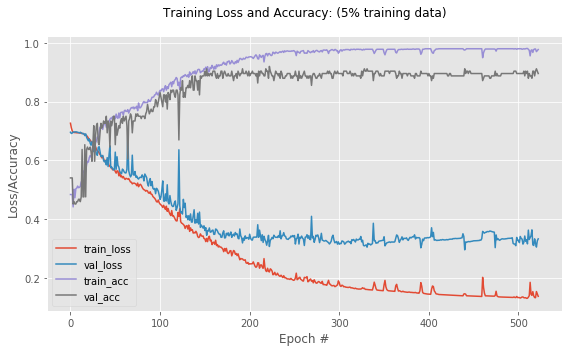


Training accuracy for model 3 with 4 % data
Plotting Model accuracy and loss versus epoch


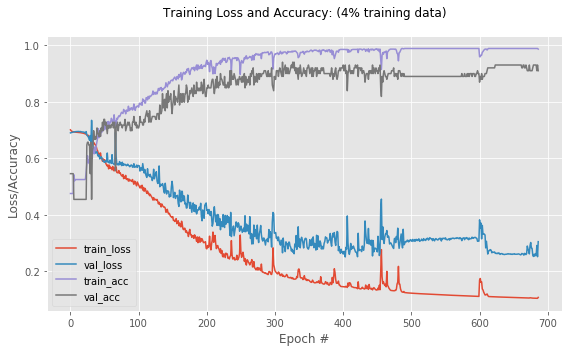


Training accuracy for model 4 with 2 % data
Plotting Model accuracy and loss versus epoch


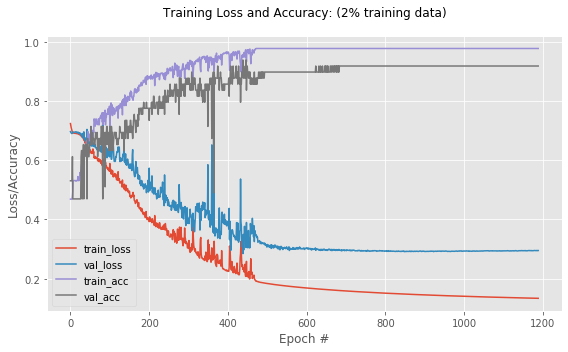


Model accuracy with hold out data for model 1 with 8 % data

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.237    | 0.933    | 0.925     | 0.943    | 0.934   
Model accuracy with hold out data for model 2 with 5 % data

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.245    | 0.930    | 0.933     | 0.926    | 0.929   
Model accuracy with hold out data for model 3 with 4 % data

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.293    | 0.910    | 0.895     | 0.928    | 0.911   
Model accuracy with hold out data for model 4 with 2 % data

Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.371    

In [0]:
fracs = [8,5,4,2] 

models, histories = frac_test(fracs, train_X, train_Y, val_X, val_Y)

for index in range(len(histories)):
    print("Training accuracy for model {} with {} % data".format(index + 1, fracs[index]))
    plotModelPerf(histories[index],
                  sup= "{}% training data".format(fracs[index]),
                  file="3_CNN_model_frac{}".format(fracs[index]))
    print('')

for index in range(len(models)):
    print("Model accuracy with hold out data for model {} with {} % data".format(index + 1, fracs[index]))
    showScores(models[index], test_X, test_Y)

##10. CV Test for data Fractions

In [0]:
fracs = [40,20,10]

for frac in fracs:
    (train_X, train_Y, folds, test_X, test_Y) = k_fold_load_and_split(gray=GRAY, 
                                                                      data_frac=frac/100.0,
                                                                      splits=10)
    cvscores = cv_test(train_X, train_Y, folds, test_X, test_Y, bs=(BATCH_SIZE-1)*frac//100 + 1)
    mu, std = np.mean(cvscores, axis=0), np.std(cvscores, axis=0)
    print("")
    print("CV Test wtih data fraction {}%".format(frac))
    print("Cross validation mean loss on test data %.3f (+/- %.3f)"% (mu[0], std[0]))
    print("Cross validation mean accuracy on test data %.2f%% (+/- %.2f%%)"% (mu[1]*100, std[1]*100))
    print("Cross validation mean precision on test data %.3f (+/- %.3f)"% (mu[2], std[2]))
    print("Cross validation mean recall on test data %.3f (+/- %.3f)"% (mu[3], std[3]))
    print("Cross validation mean F1 on test data %.3f (+/- %.3f)"% (mu[4], std[4]))
    print("")

k_fold_load_and_split called for 40.0% data fraction
Test split 10.0%. Number of folds 10%
load_and_split_data called with Val/Test split fraction 0/0.1
Loading images for class 0 from ./dataset/color//Uninfected
Completed loading 13779 (of 13779) images

Loading images for class 1 from ./dataset/color//Parasitized
Completed loading 13779 (of 13779) images

Training data set size is (24802, 44, 44, 3) (24802,)
Test data data set size is (2756, 44, 44, 3) (2756,)
Training data labels and counts are [0 1] [12401 12401]
Test data labels and counts are [0 1] [1378 1378]
Limiting training data to 9920/1102 samples
Build and train on fold number 1
	acc: 95.06% {} model score at end of training (with fold test data)
	acc: 96.28% best model score on test set
Build and train on fold number 2
	acc: 95.46% {} model score at end of training (with fold test data)
	acc: 96.46% best model score on test set
Build and train on fold number 3
Epoch 00021: early stopping
	acc: 48.99% {} model score at end

In [0]:
fracs = [80, 60]

for frac in fracs:
    (train_X, train_Y, folds, test_X, test_Y) = k_fold_load_and_split(gray=GRAY, 
                                                                      data_frac=frac/100.0,
                                                                      splits=10)
    cvscores = cv_test(train_X, train_Y, folds, test_X, test_Y, 
                       bs=BATCH_SIZE, 
                       nepochs = (EPOCHS * 100)//frac)
    mu, std = np.mean(cvscores, axis=0), np.std(cvscores, axis=0)
    print("")
    print("CV Test wtih data fraction {}%".format(frac))
    print("Cross validation mean loss on test data %.3f (+/- %.3f)"% (mu[0], std[0]))
    print("Cross validation mean accuracy on test data %.2f%% (+/- %.2f%%)"% (mu[1]*100, std[1]*100))
    print("Cross validation mean precision on test data %.3f (+/- %.3f)"% (mu[2], std[2]))
    print("Cross validation mean recall on test data %.3f (+/- %.3f)"% (mu[3], std[3]))
    print("Cross validation mean F1 on test data %.3f (+/- %.3f)"% (mu[4], std[4]))
    print("")

k_fold_load_and_split called for 80.0% data fraction
Test split 10.0%. Number of folds 10
load_and_split_data called with Val/Test split fraction 0/0.1
Loading images for class 0 from ./dataset/color//Uninfected
Completed loading 13779 (of 13779) images

Loading images for class 1 from ./dataset/color//Parasitized
Completed loading 13779 (of 13779) images

Training data set size is (24802, 44, 44, 3) (24802,)
Test data data set size is (2756, 44, 44, 3) (2756,)
Training data labels and counts are [0 1] [12401 12401]
Test data labels and counts are [0 1] [1378 1378]
Limiting training data to 19841/2204 samples
Build and train on fold number 1
	acc: 95.87% {} model score at end of training (with fold test data)
	acc: 94.92% best model score on test set
Build and train on fold number 2
	acc: 95.97% {} model score at end of training (with fold test data)
	acc: 94.74% best model score on test set
Build and train on fold number 3
	acc: 95.06% {} model score at end of training (with fold test

##10. Confusion Matrix 

In [0]:
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('/content/gdrive/My Drive/MSc AI/Project/Code/Models/' + '3_Best_CNN_model.h5')
showScores(model, test_X, test_Y)

resultsProb = model.predict(test_X)
# calculate predicted results from probabilities (horizontal axis)
results = np.argmax(resultsProb, axis=1) 
# Show the confusion matrix
print(confusion_matrix(test_Y, results))


Scores for classification model
| Loss     | Accuracy | Precision | Recall   | F1      
| -------- | -------- | --------  | -------- | --------
| 0.185    | 0.959    | 0.952     | 0.967    | 0.959   
[[1311   67]
 [  46 1332]]


## Mis-classified images

In [0]:
# Show the False Positive IMages
show_misclassified(test_Y, results, ground_truth=0, file='3_CNN_misclassified_T0P1.png')

In [0]:
# Show False Negatives
show_misclassified(test_Y, results, ground_truth=1, file='3_CNN_misclassified_T1P0.png')

## 10. Copy saved files to Google drive. 

In [0]:
%%bash
cp -f ./*.h5 "$GPATH/Models"
cp -f ./*.json "$GPATH/Models"
cp -f ./*.pickle "$GPATH/Models"
cp -f ./*.png "$GPATH/Images"

cp: cannot stat './*.json': No such file or directory
cp: cannot stat './*.pickle': No such file or directory
cp: cannot stat './*.png': No such file or directory
